# Notes
This Jupyter Notebook provides you with some basic scaffolding to get you started on the [A2: Gesture Recognizer assignment](https://canvas.uw.edu/courses/1199409/assignments/4176980). In particular, I wrote some parser code and some initial data structures to parse and load the gesture logs recorded with the [A2: Gesture Logger](https://github.com/jonfroehlich/CSE590Sp2018/tree/master/A02-GestureLogger).

## Getting Started
1. The first thing you need to do is to change the logPath variable to point to the directory with your gesture logs. Scroll down to the "Load the Data" cell
2. Then, you should be able to select Cell->Run All in the File Menu above and the data should be read in.
3. Hopefully, in class, we will have time to visualize and analyze these signals a bit

## Dynamic Time Warping
If you choose to explore Dynamic Time Warping (DTW), I recommend fastdtw. You can install this by typing the following in cell:
```
import sys
!{sys.executable} -m pip install fastdtw
```
See https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/ for more details

In [248]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        self.xSquared = np.multiply(self.x, self.x)
        self.ySquared = np.multiply(self.y, self.y)
        self.zSquared = np.multiply(self.z, self.z)
        
        self.mag = np.sqrt(np.add(self.xSquared, self.ySquared, self.zSquared))
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)
        
    def low_pass_filter(self):
        

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Gyroscope", *parsedGyroLogData[1:])
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))

In [249]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(logPath, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(logPath, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

In [386]:
# Load the data

# You should change the path to the location of the log files on your system
# logPath = '/Users/jonf/Dropbox/CSE590_UbiComp/Git/CSE590Sp2018p/A02-GestureRecognizer/JupyterAnalysis/GestureLogs'
# logPath = "D:\Dropbox\CSE590_UbiComp\Git\CSE590Sp2018\A02-GestureRecognizer\JonGestureLogs"

#logPath = "C:\\Users\\ribarua\\Desktop\\rishi-barua\\CSE590Sp2018\\A02-GestureRecognizer\\JonGestureLogs"
logPath = "C:\\Users\\ribarua\\Desktop\\rishi-barua\\CSE590Sp2018\\A02-GestureRecognizer\\MyGestureLogs"
mapGestureToTrials = parse_and_create_gesture_trials(logPath)


Found 110 csv files in C:\Users\ribarua\Desktop\rishi-barua\CSE590Sp2018\A02-GestureRecognizer\MyGestureLogs
Found 11 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Your Custom Gesture'
Max trial length across all gesture is 'Midair Zorro Z' Trial 0 with 155 sensor events. Resizing all arrays to match


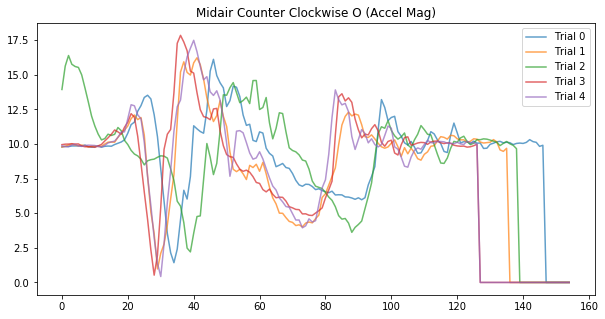

In [387]:
# Now, we need to plot and explore the data. Come up with a shape matching approach 
# and a trained model approach (e.g., decision tree, SVM) to classify the gestures

# For example, here's how you would plot one of the signals
from random import randint
gestureNamesSorted = sorted(mapGestureToTrials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = mapGestureToTrials[randomGestureName]
trialNum = 0
for trial in gestureTrials:
    axes.plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
    trialNum = trialNum + 1

# set the title and show the legend
axes.set_title(randomGestureName + " (Accel Mag)")
axes.legend()


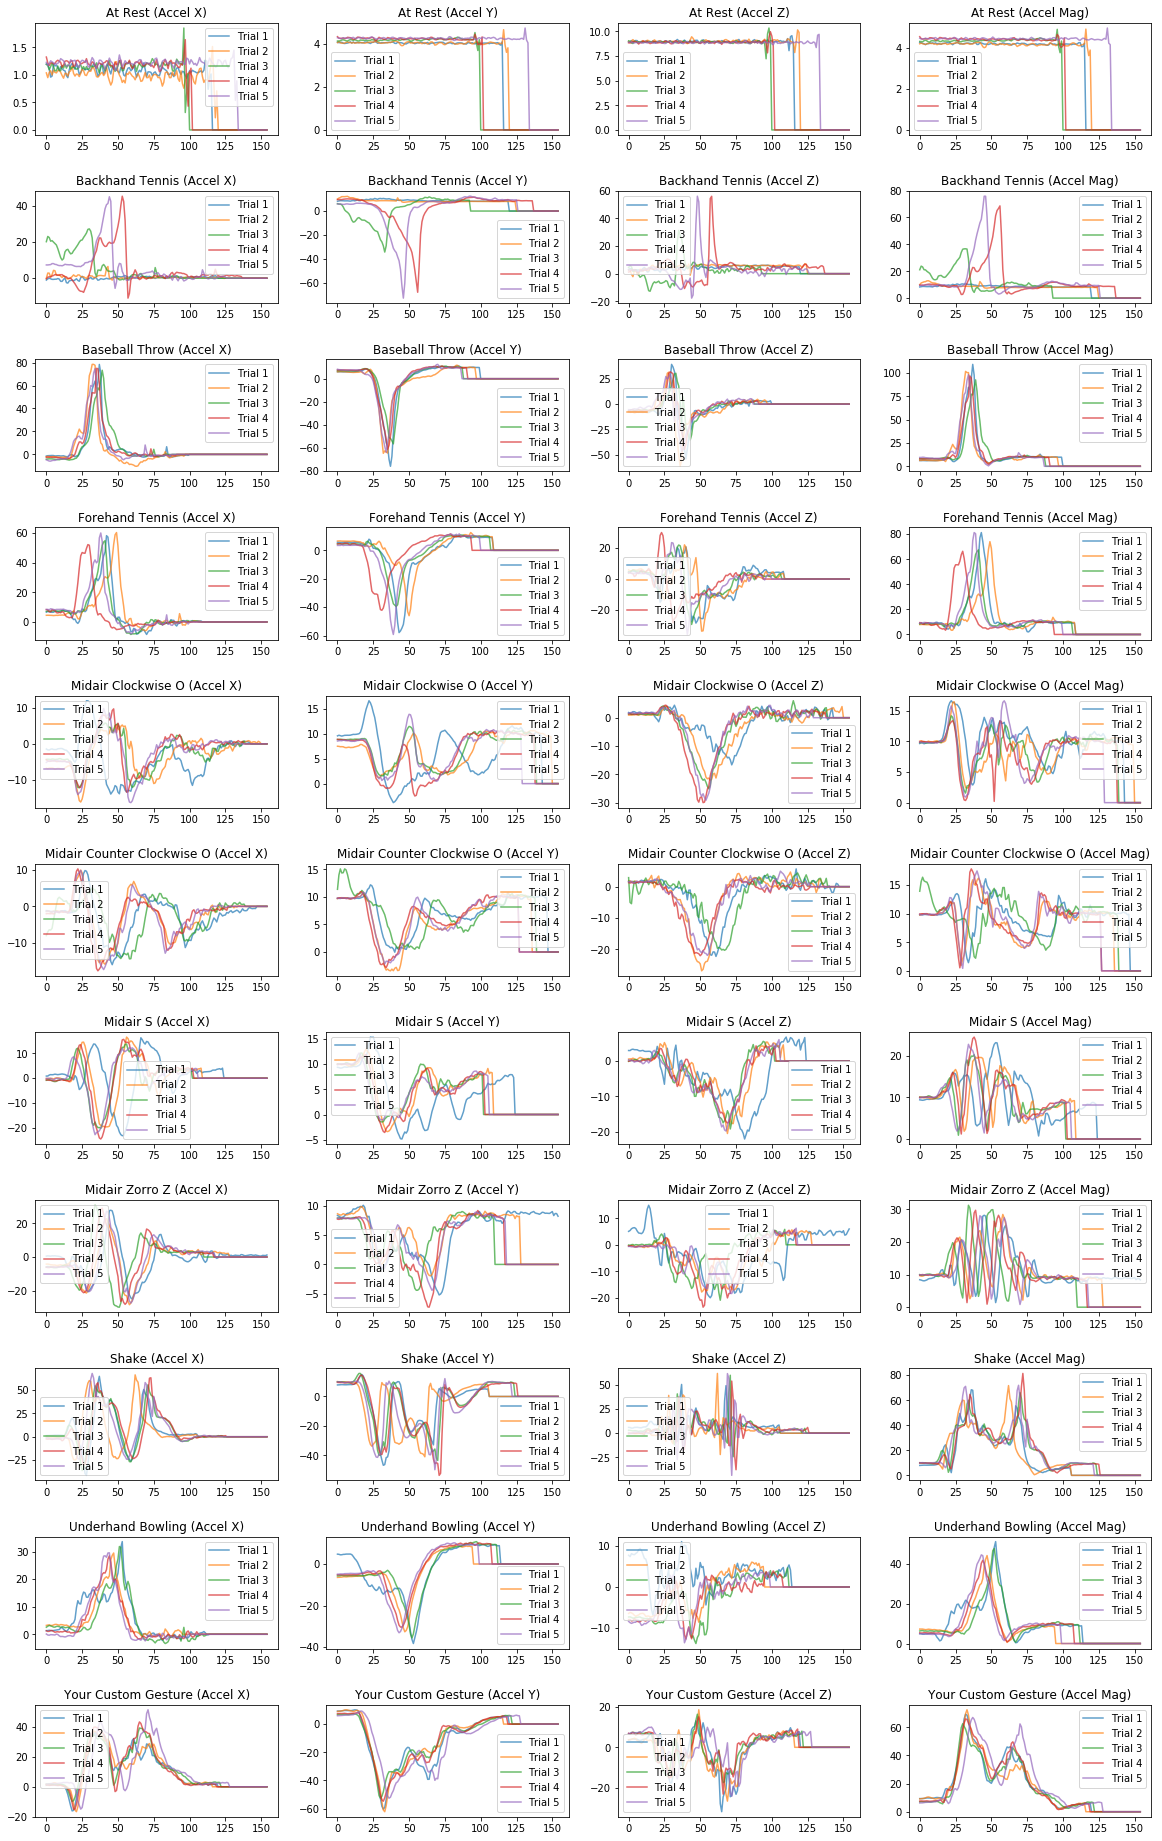

In [388]:
# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1


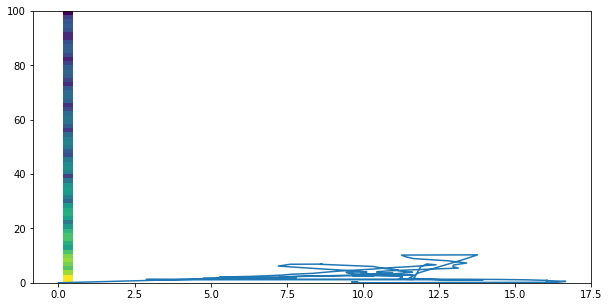

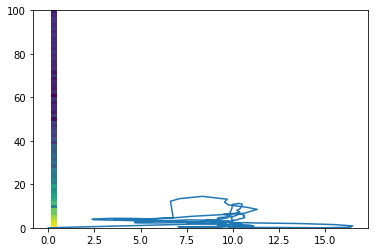

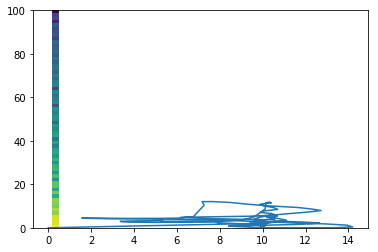

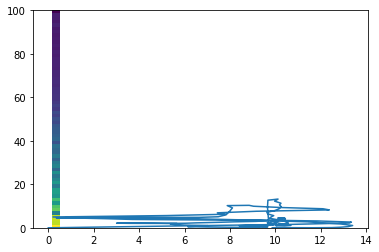

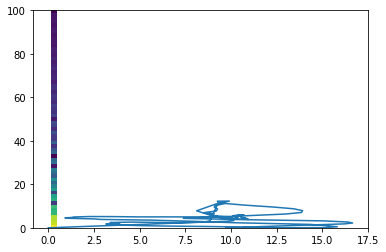

In [413]:
#Spectogram

from random import randint
gestureNamesSorted = sorted(mapGestureToTrials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = mapGestureToTrials[randomGestureName]
Fs = int(1.0/0.005)
#ax1 = plt.subplot(211)

#plt.subplot(212, sharex=ax1)



trialNum = 0
for trial in gestureTrials:
    plt.plot(trial.accel.mag, trial.gyro.mag, label="Trial {}".format(trialNum))
    Pxx, freqs, bins, im = plt.specgram(trial.gyro.mag, NFFT=128, Fs=Fs, noverlap=64)   
    plt.show()
    trialNum = trialNum + 1

# set the title and show the legend
axes.set_title(randomGestureName + " (Accel Mag)")
axes.legend()



In [421]:
import sys
!{sys.executable} -m pip install fastdtw

# Given the online discussion about k-fold implementations, I thought I would provide my own. Note that sci-kit learn also 
# has built-in functionality for this (I've never used it but worth checking out):
# http://scikit-learn.org/stable/modules/cross_validation.html
from random import randint

# Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial for that fold
# if createNewKFold is True, returns a new random fold, otherwise returns same fold setup as before 
# (this is to better enable repeat experimentation)
fixedFoldsToMapGestureToTrial = None
def generate_kfolds(mapGestureToTrials, numFolds, createNewKFold=False):
    global fixedFoldsToMapGestureToTrial
    
    if createNewKFold is False and fixedFoldsToMapGestureToTrial is not None:
        return fixedFoldsToMapGestureToTrial
    
    # Quick check to make sure that there are numFolds of gesture trials for each gesture
    for gestureName, trials in mapGestureToTrials.items():
        if numFolds != len(trials):
            raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each gesture. Gesture '{}' has {} trials"
                             .format(numFolds, gestureName, len(trials)))


    numGestures = len(mapGestureToTrials)
    tmpMapGestureToTrials = dict()
    for gestureName, trials in mapGestureToTrials.items():
        tmpMapGestureToTrials[gestureName] = list(trials)
    
    gestureNames = list(mapGestureToTrials.keys())

    # create folds
    foldToMapGestureToTrial = list()
    for i in range(0, numFolds):
        curFoldMapGestureToTrial = dict()
        foldToMapGestureToTrial.append(curFoldMapGestureToTrial)
        
        for j in range(0, numGestures):
            curGestureName = gestureNames[j]
            trialList = tmpMapGestureToTrials[curGestureName]
            randTrialIndex = 0
            if (len(trialList) > 0):
                randTrialIndex = randint(0, len(trialList) - 1)

            randTrial = trialList[randTrialIndex]
            curFoldMapGestureToTrial[curGestureName] = randTrial
            del trialList[randTrialIndex]
    
    if fixedFoldsToMapGestureToTrial is None:
        fixedFoldsToMapGestureToTrial = foldToMapGestureToTrial
    
    return foldToMapGestureToTrial

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [415]:
# Playing around with plotting confusion matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

The feature vector size is: 6
Accuracy in fold =  5  * 100/ ( 5 + 6 ) =  45.45454545454545
The feature vector size is: 6


C:\Users\ribarua\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Accuracy in fold =  9  * 100/ ( 9 + 2 ) =  81.81818181818181
The feature vector size is: 6
Accuracy in fold =  7  * 100/ ( 7 + 4 ) =  63.63636363636363
The feature vector size is: 6
Accuracy in fold =  11  * 100/ ( 11 + 0 ) =  100.0
The feature vector size is: 6
Accuracy in fold =  9  * 100/ ( 9 + 2 ) =  81.81818181818181
Per gesture Accuracy: 
At Rest Accuracy is  100.0
Backhand Tennis Accuracy is  40.0
Baseball Throw Accuracy is  80.0
Forehand Tennis Accuracy is  80.0
Midair Clockwise O Accuracy is  80.0
Midair Counter Clockwise O Accuracy is  80.0
Midair S Accuracy is  80.0
Midair Zorro Z Accuracy is  100.0
Shake Accuracy is  60.0
Underhand Bowling Accuracy is  60.0
Your Custom Gesture Accuracy is  60.0
Total Accuracy=  74.54545454545455
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 2 0 0 0 0]
 [0 0 4 1 0 0 0 0 0 0 0]
 [0 0 1 4 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 1 0 0 0]
 [0 0 0 0 0 4 0 1 0 0 0]
 [0 0 0 0 0 1 4 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0

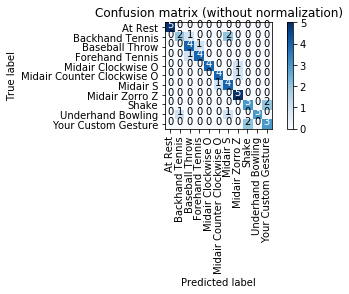

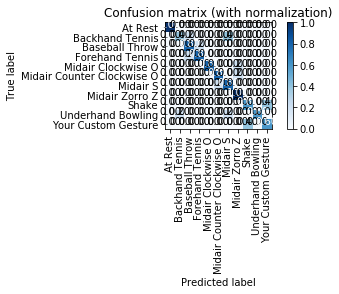

In [424]:
#DTW Shape Matching


def meanlist(numbers):
    sum = 0
    count = 0
    for num in numbers:
        sum = sum + num
        count = count + 1
        
    return sum/count

def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def create_dtw_vector(trial):
    from scipy import signal
    from scipy.fftpack import fft
    b, a = signal.butter(3, 0.6)
    zi = signal.lfilter_zi(b, a)
    accl, _ = signal.lfilter(b, a, trial.accel.mag, zi=zi*trial.accel.mag[0])
    gyl, _ = signal.lfilter(b, a, trial.gyro.mag, zi=zi*trial.gyro.mag[0])
    
    trial_fft_accel_mag = fft(accl)
    trial_fft_gyro_mag = fft(gyl)
    return [trial_fft_gyro_mag.max(), trial_fft_accel_mag.max(), trial.accel.mag.max(), trial.gyro.mag.max(), trial_fft_gyro_mag.min(), trial_fft_accel_mag.min()]

def create_dtw_vector_dummy():
    return [0, 0, 0, 0, 0, 0]

def get_dtw_distance(x, y):
    from scipy.spatial import distance
    from scipy.spatial.distance import euclidean
    from fastdtw import fastdtw
    
    
    dis, path = fastdtw(x, y, dist = distance.euclidean)
    #dis = distance.euclidean(x, y)
    
    return dis

def find_min_dtw(testValue, trainingArr):
    
    minValue = 1000000
    #print (testValue)
    for key, value in trainingArr.items():
        #print (key, value)
        dis = get_dtw_distance(testValue, value)
        #print (key, dis)
        if (dis < minValue):
            minValue = dis
            minGesture = key
    
    return minGesture, minValue
        
def vec_add(vec1, vec2):
    count = 0
    vec3 = []
    for item in vec2:
        vec3.append(item + vec1[count])
        count = count + 1
    return vec3

def vec_divide(vec1, num):
    vec3 = []
    for item in vec1:
        vec3.append(item/num)
        
    return vec3

def dtf_run(trainingFolds, testFold):
        
    import random
    
    # calculate the number of training trials
    numOfTrainingTrials = 0
    for trainingFold in trainingFolds:
        numOfTrainingTrials = numOfTrainingTrials + len(trainingFold)
        
    #print (numOfTrainingTrials)
        
    # Now figure out the number of features from the create_feature_vector call
    # This is just a dummy call to figure out the number of features in order to
    # properly initialize our trainingData matrix
    tmpTrainingTrial = random.choice(list(trainingFolds[0].values()))
    numFeatures = len(create_dtw_vector(tmpTrainingTrial))
    print("The feature vector size is: {}".format(numFeatures))
     
    # now we can setup our training data structures  
    # each row in our trainingData matrix corresponds to a trial
    # and each column corresponds to a feature 
    trainingData = np.zeros([numOfTrainingTrials, numFeatures])
    
    trainingArr = {}
    for trainingGestureName in gestureNamesSorted:
        trainingArr[trainingGestureName] = create_dtw_vector_dummy()
        
    for trainingFold in trainingFolds:
        for trainingGestureName, trainingTrial in trainingFold.items():            
            vectorTrial = create_dtw_vector(trainingTrial)            
            trainingArr[trainingGestureName] = vec_add(trainingArr[trainingGestureName], vectorTrial)
    for trainingGestureName in gestureNamesSorted:        
        trainingArr[trainingGestureName] = vec_divide(trainingArr[trainingGestureName], 4)
    #for key, value in trainingArr.items():
        #print (key, value)
    
    
    
    countPass = 0
    countFail = 0
    # Now setup the testData data structure
    testData = np.zeros([len(testFold), numFeatures])
    testRow = 0
    countPass = 0
    countFail = 0
    testTrials = list()
    for testGestureName, testTrial in testFold.items():
        testTrials.append(testTrial)
        vecTest = create_dtw_vector(testTrial)        
        #print("Attempting to predict: {}".format(testGestureName))
        answerExpected.append(testGestureName)
        val, num = find_min_dtw(vecTest, trainingArr)
        #print("DTW prediction: {}".format(val))
        answerActual.append(val)
        
        totalGestures[testGestureName] = totalGestures[testGestureName] + 1
        if (val == testGestureName):
            countPass = countPass + 1        
            correctGestures[testGestureName] = correctGestures[testGestureName] + 1
        else:
            countFail = countFail + 1
            
    #print (trainingData)
    
    print ("Accuracy in fold = ", (countPass), " * 100/","(", countPass, "+", countFail, ") = ", (countPass* 100)/ (countFail + countPass))
    
    return countPass, countFail

numFolds = get_min_num_of_trials(mapGestureToTrials)
numGestures = len(mapGestureToTrials)
numTrials = get_total_num_of_trials(mapGestureToTrials)
foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials, numFolds)
    
gestureNames = list(mapGestureToTrials.keys())

foldIndex = 0
mapGestureNameToCorrectMatchCnt = dict()
mapGestureNameToPredictionResultList = dict()
trainingData = []
classLabels = np.array([])

count = 0
trainingFolds = []
testFold = []

for i in range(0, numFolds):
    trainingFolds.append([])
    testFold.append([])
    for j in range(i, numFolds + i -1):        
        trainingFolds[i].append(foldToMapGestureToTrial[j%numFolds])
    testFold[i] = foldToMapGestureToTrial[(numFolds + i)% numFolds]

#print ("testfold = ", testFold)
answerExpected = []
answerActual = []
numCorrect = 0
total = 0
correctGestures = {}
totalGestures = {}
for gestureName in gestureNamesSorted:
    correctGestures[gestureName] = 0
    totalGestures[gestureName] = 0
    


for i in range(0, numFolds):
    ctpass, ctfail =dtf_run(trainingFolds[i], testFold[i])
    total = ctfail + total
    numCorrect = ctpass + numCorrect

total = total + numCorrect

print("Per gesture Accuracy: ")
for gestureName in gestureNamesSorted:
    print (gestureName, "Accuracy is ", (correctGestures[gestureName] * 100)/totalGestures[gestureName])

print ("Total Accuracy= ", (numCorrect * 100)/total)
y_true = answerExpected
y_pred = answerActual

labels=gestureNamesSorted
cm = confusion_matrix(y_true, y_pred, labels)
plt.figure()
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()

In [58]:
# Print out the folds
numFolds = 5
print(numFolds)
foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials, numFolds)

# debug check folds
foldIndex = 0
print("DEBUG: PRINTING OUT FOLDS")
for fold in foldToMapGestureToTrial:
    print("Fold: ", foldIndex)
    for gestureName, trial in fold.items():
        print("\t Gesture: {} Trial: {}".format(gestureName, trial.trialNum))
    foldIndex = foldIndex + 1

5
DEBUG: PRINTING OUT FOLDS
Fold:  0
	 Gesture: At Rest Trial: 4
	 Gesture: Backhand Tennis Trial: 0
	 Gesture: Baseball Throw Trial: 3
	 Gesture: Forehand Tennis Trial: 2
	 Gesture: Midair Clockwise O Trial: 4
	 Gesture: Midair Counter Clockwise O Trial: 4
	 Gesture: Midair S Trial: 1
	 Gesture: Midair Zorro Z Trial: 3
	 Gesture: Shake Trial: 3
	 Gesture: Underhand Bowling Trial: 4
Fold:  1
	 Gesture: At Rest Trial: 1
	 Gesture: Backhand Tennis Trial: 1
	 Gesture: Baseball Throw Trial: 0
	 Gesture: Forehand Tennis Trial: 0
	 Gesture: Midair Clockwise O Trial: 2
	 Gesture: Midair Counter Clockwise O Trial: 3
	 Gesture: Midair S Trial: 0
	 Gesture: Midair Zorro Z Trial: 2
	 Gesture: Shake Trial: 0
	 Gesture: Underhand Bowling Trial: 2
Fold:  2
	 Gesture: At Rest Trial: 0
	 Gesture: Backhand Tennis Trial: 2
	 Gesture: Baseball Throw Trial: 2
	 Gesture: Forehand Tennis Trial: 1
	 Gesture: Midair Clockwise O Trial: 0
	 Gesture: Midair Counter Clockwise O Trial: 0
	 Gesture: Midair S Trial:

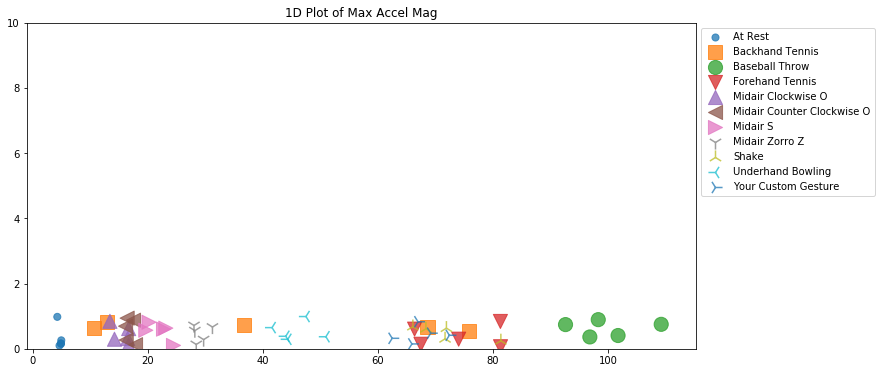

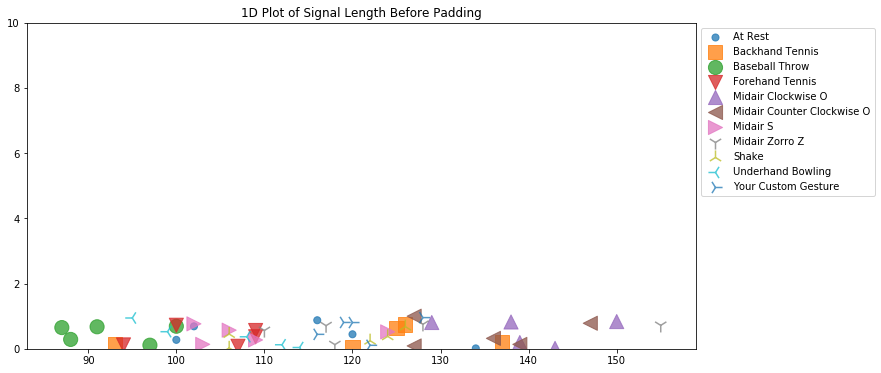

In [393]:
# Playing around with 1D Explorations of data
# TODO: brainstorm and experiment with at least five features that you think might be highly differentiable in the 
# gesture dataset. I've started by plotting two simple features: the maximum magnitude and the length of the trial

import itertools

mapMarkerToDesc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

# Plots the maximum magnitude of each trial's acceleration signal
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.mag.max() for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Max Accel Mag")
plt.show()


# Plots the length of each gesture trial
markers = list(mapMarkerToDesc.keys())
marker = itertools.cycle(markers)
plt.figure(figsize=(12, 6))
for gestureName, trials in mapGestureToTrials.items():
    x = list(trial.accel.signalLengthBeforePadding for trial in trials)
    y = np.random.rand(len(x))
    s = [200] * len(x)
    plt.scatter(x, y, alpha=0.75, marker=next(marker), s=s, label=gestureName)

plt.ylim((0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))    
plt.title("1D Plot of Signal Length Before Padding")
plt.show()

# Add your own down here!


In [ ]:
tryArr1 = np.array([])


44
The feature vector size is: 3
Accuracy =  11  * 100/ ( 0 + 11 ) =  100.0
44
The feature vector size is: 3
Accuracy =  11  * 100/ ( 0 + 11 ) =  100.0
44
The feature vector size is: 3
Accuracy =  11  * 100/ ( 0 + 11 ) =  100.0
44
The feature vector size is: 3
Accuracy =  11  * 100/ ( 0 + 11 ) =  100.0
44
The feature vector size is: 3
Accuracy =  11  * 100/ ( 0 + 11 ) =  100.0
Per gesture Accuracy: 
At Rest Accuracy is  100.0
Backhand Tennis Accuracy is  100.0
Baseball Throw Accuracy is  100.0
Forehand Tennis Accuracy is  100.0
Midair Clockwise O Accuracy is  100.0
Midair Counter Clockwise O Accuracy is  100.0
Midair S Accuracy is  100.0
Midair Zorro Z Accuracy is  100.0
Shake Accuracy is  100.0
Underhand Bowling Accuracy is  100.0
Your Custom Gesture Accuracy is  100.0
Total Accuracy=  90.9090909090909
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 

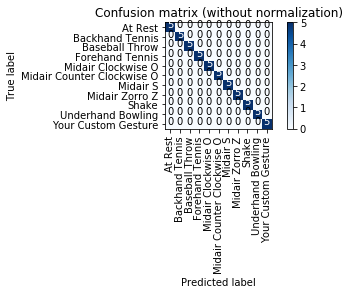

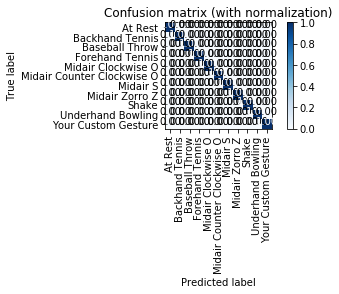

In [426]:
# Now, let's try to build an SVM using some of the features you brainstormed. 
# We're going to start with the simplest possible SVM using only one feature
# 
# Some nice resources:
#  - Official sci-kit learn (Start here!): http://scikit-learn.org/stable/modules/svm.html
#  - A simple classification example using scikit: https://dbaumgartel.wordpress.com/2014/03/10/a-scikit-learn-example-in-10-lines/
#  - A nice video overview of SVM: https://youtu.be/N1vOgolbjSc
#  
#

def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def create_feature_vector(trial):
    return [trial.accel.mag.max(), trial.accel.signalLengthBeforePadding, trial.gyro.mag.max()]
    #return [trial.accel.mag.max(), trial.gyro.mag.max(), mean(trial.accel.mag), mean(trial.gyro.mag)]


def svm_run(trainingFolds, testFold):
        
    import random
        #for gestureName, trial in trainingFolds.items():

         #   vec = create_simple_feature_vector(trial)
          #  trainingData.append([])
          #  trainingData[j] = (vec)
          #  j = j + 1
          #  classLabels = np.append(classLabels, trial.gestureName)
          #  #print (trial.accel.mag.max(), gestureName)


    # calculate the number of training trials
    numOfTrainingTrials = 0
    for trainingFold in trainingFolds:
        numOfTrainingTrials = numOfTrainingTrials + len(trainingFold)
        
    print (numOfTrainingTrials)
        
    # Now figure out the number of features from the create_feature_vector call
    # This is just a dummy call to figure out the number of features in order to
    # properly initialize our trainingData matrix
    tmpTrainingTrial = random.choice(list(trainingFolds[0].values()))
    numFeatures = len(create_feature_vector(tmpTrainingTrial))
    print("The feature vector size is: {}".format(numFeatures))
     
    # now we can setup our training data structures  
    # each row in our trainingData matrix corresponds to a trial
    # and each column corresponds to a feature
    trainingData = np.zeros([numOfTrainingTrials, numFeatures])
    trainingTrials = list()
    trainingLabels = np.array([])
    
    row = 0
    for trainingFold in trainingFolds:
        for trainingGestureName, trainingTrial in trainingFold.items():
            trainingData[row] = create_feature_vector(trainingTrial)
            trainingLabels = np.append(trainingLabels, trainingTrial.gestureName)
            trainingTrials.append(trainingTrial)
            row = row + 1
    
    
    clf = svm.SVC()
    clf.fit(trainingData, trainingLabels) 
    
    countPass = 0
    countFail = 0
    # Now setup the testData data structure
    testData = np.zeros([len(testFold), numFeatures])
    testRow = 0
    groundtruthLabels = list()
    testTrials = list()
    for testGestureName, testTrial in testFold.items():
        testTrials.append(testTrial)
        testData[testRow] = create_feature_vector(testTrial)
        groundtruthLabels.append(testGestureName)
        testRow = testRow + 1
        totalGestures[testGestureName] = totalGestures[testGestureName] + 1
        #print("Attempting to predict: {}".format(testGestureName))
        answerExpected.append(testGestureName)
        svmPrediction = clf.predict([create_feature_vector(testTrial)])
        #print("SVM prediction: {}".format(svmPrediction[0]))
        answerActual.append(svmPrediction[0])
        if (svmPrediction[0] == testGestureName):
            countPass = countPass + 1
            correctGestures[testGestureName] = correctGestures[testGestureName] +1 
        else:
            countFail = countFail + 1
    #print (trainingData)
    
    print ("Accuracy = ", (countPass), " * 100/","(", countFail, "+", countPass, ") = ", (countPass* 100)/ (countFail + countPass))
    return countPass, countFail


    
    # for row in range(0,len(classLabels)):
    #     print("gestureName={} values={}".format(classLabels[row], trainingData[row]))

    # Setup SVM
    #trainingData = trainingData.reshape(-1, 1) # for 1D input feature vectors, we have to reshape like this

    # Traing our SVM
    #print(trainingData)
    #clf = svm.SVC()
    #clf.fit(trainingData, classLabels) 

    # Test our SVM
    # fold 0 will be our test fold
    #print (numFolds)
    #testFold = foldToMapGestureToTrial[0]
    #for gestureName, trial in testFold.items():
     #   print("Attempting to predict: {}".format(gestureName))
      #  svmPrediction = clf.predict([create_simple_feature_vector(trial)])
      #  print("SVM prediction: {}".format(svmPrediction[0]))

from sklearn import svm


numFolds = get_min_num_of_trials(mapGestureToTrials)
numGestures = len(mapGestureToTrials)
numTrials = get_total_num_of_trials(mapGestureToTrials)
foldToMapGestureToTrial = generate_kfolds(mapGestureToTrials, numFolds)
    
gestureNames = list(mapGestureToTrials.keys())

# now build an SVM
# Currently training on folds 1-4 and testing on fold 0 (just for now)
foldIndex = 0
mapGestureNameToCorrectMatchCnt = dict()
mapGestureNameToPredictionResultList = dict()
trainingData = []
classLabels = np.array([])

count = 0
trainingFolds = []
testFold = []

for i in range(0, numFolds):
    trainingFolds.append([])
    testFold.append([])
    for j in range(i, numFolds + i -1):        
        trainingFolds[i].append(foldToMapGestureToTrial[j%numFolds])
    testFold[i] = foldToMapGestureToTrial[(numFolds + i)% numFolds]

#print ("testfold = ", testFold)

answerExpected = []
answerActual = []
numCorrect = 0
total = 0
correctGestures = {}
totalGestures = {}
for gestureName in gestureNamesSorted:
    correctGestures[gestureName] = 0
    totalGestures[gestureName] = 0
    


for i in range(0, numFolds):
    numCorrect, total = svm_run(trainingFolds[i], testFold[i])
    total = ctfail + total
    numCorrect = ctpass + numCorrect

total = total + numCorrect

print("Per gesture Accuracy: ")
for gestureName in gestureNamesSorted:
    print (gestureName, "Accuracy is ", (correctGestures[gestureName] * 100)/totalGestures[gestureName])

print ("Total Accuracy= ", (numCorrect * 100)/total)



y_true = answerExpected
y_pred = answerActual
labels=gestureNamesSorted
cm = confusion_matrix(y_true, y_pred, labels)
plt.figure()
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()
